<h4>9. Load the MNIST dataset (introduced in Chapter 3) and split it into a training set and a test set (take the first 60,000 instances for training, and the remaining 10,000 for testing). Train a Random Forest classifier on the dataset and time how long it takes, then evaluate the resulting model on the test set. Next, use PCA to reduce the dataset’s dimensionality, with an explained variance ratio of 95%. Train a new Random Forest classifier on the reduced dataset and see how long it takes. Was training much faster? Next evaluate the classifier on the test set: how does it compare to the previous classifier?
</h4>

In [1]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split    

digits_data = fetch_openml('mnist_784', version=1, cache=True, as_frame=False)
X_train, X_test, y_train, y_test = train_test_split(digits_data.data, digits_data.target, test_size=0.2, random_state=42) 

c:\Users\cozie\Documents\Learning\Hands on ML\venv\lib\site-packages\sklearn\datasets\_openml.py:1002: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [2]:
from sklearn.ensemble import RandomForestClassifier
import time
from sklearn.metrics import accuracy_score

In [3]:
forestClassifier = RandomForestClassifier(n_estimators=100, random_state=0)
start = time.time()
forestClassifier.fit(X_train, y_train)
end = time.time()
print("Time taken to train the model: ", end - start, "seconds")
print("Accuracy on test set: ", 100*forestClassifier.score(X_test, y_test), "%")

Time taken to train the model:  69.74638748168945 seconds
Accuracy on test set:  96.74285714285715 %


In [4]:
from sklearn.decomposition import PCA
pca = PCA(n_components=0.95)
X_train_reduced = pca.fit_transform(X_train)
print(X_train_reduced.shape)
print(X_train.shape)

(56000, 154)
(56000, 784)


We reduced the image from 784 dimensions to 154 that explained 95% of the variance in the training set

In [5]:
forestClassifierPCA = RandomForestClassifier(n_estimators=100, random_state=0)
start = time.time()
forestClassifierPCA.fit(X_train_reduced, y_train)
end = time.time()
print("Time taken to train the model: ", end - start, "seconds")
X_test_reduced = pca.transform(X_test)
print("Accuracy on test set: ", 100*forestClassifierPCA.score(X_test_reduced, y_test), "%")

Time taken to train the model:  296.33319568634033 seconds
Accuracy on test set:  94.58571428571429 %


The model using the transformed training data takes too much time to train and the accuracy has dropped a little. So in this case it is not worth it to use PCA (maybe using another algorithm for classification will be better).

<h4>10. Use t-SNE to reduce the MNIST dataset down to two dimensions and plot the result using Matplotlib. You can use a scatterplot using  different colors to represent each image’s target class. Alternatively, you can write colored digits at the location of each instance, or even plot scaled-down versions of the digit images themselves (if you plot all digits, the visualization will be too cluttered, so you should either draw a random sample or plot an instance only if no other instance has already been plotted at a close distance). You should get a nice visualization with well-separated clusters of digits. Try using other dimensionality reduction algorithms such as PCA, LLE, or MDS and compare the resulting visualizations.</h4>

In [7]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

In [55]:
tsne = TSNE(n_components=2, random_state=0, n_jobs=-1)
indexes = np.random.choice(X_train.shape[0], 10000, replace=False)
start = time.time()
X_subset = tsne.fit_transform(X_train[indexes])
print('Time elapsed: {} seconds'.format(time.time() - start))
y_subset = y_train[indexes]
y_subset = y_subset.astype(int)


Time elapsed: 81.66157245635986 seconds


(-87.68072776794433, 88.48835258483886, -89.41795806884765, 87.03566436767578)

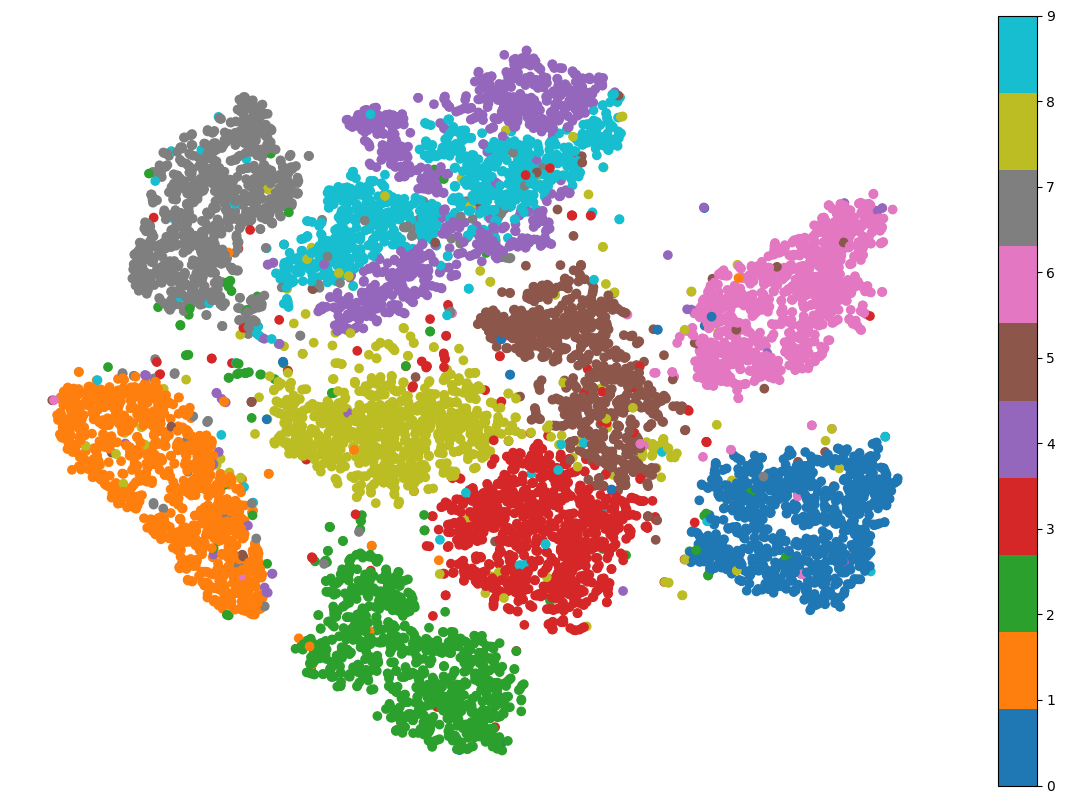

In [56]:
plt.figure(figsize=(15, 10))
plt.scatter(X_subset[:, 0], X_subset[:, 1], c=y_subset, cmap=plt.cm.tab10)
plt.colorbar()
plt.axis('off')

Using t-sne to reduce the dimensionality of the data and plot it in 2D, we see some clusters in the data that represent each digit. This is a good sign that our model will be able to classify the data well. Let's test some other dimensionality reduction techniques to see if we can get better results.

In [19]:
from sklearn.manifold import LocallyLinearEmbedding
from sklearn.manifold import MDS
from sklearn.decomposition import PCA

In [40]:
pca = PCA(n_components=2)
lle = LocallyLinearEmbedding(n_components=2, n_neighbors=10, n_jobs=-1)
times = []
X_transformed = []
for method in [pca, lle]:
    start = time.time()
    X_transformed.append(method.fit_transform(X_train[indexes]))
    print(method.__class__.__name__, 'took', time.time() - start, 'seconds')

PCA took 1.6239230632781982 seconds
LocallyLinearEmbedding took 139.96320414543152 seconds


(-0.021736600933685624,
 0.01926794806748831,
 -0.050384248134517244,
 0.02124997112969984)

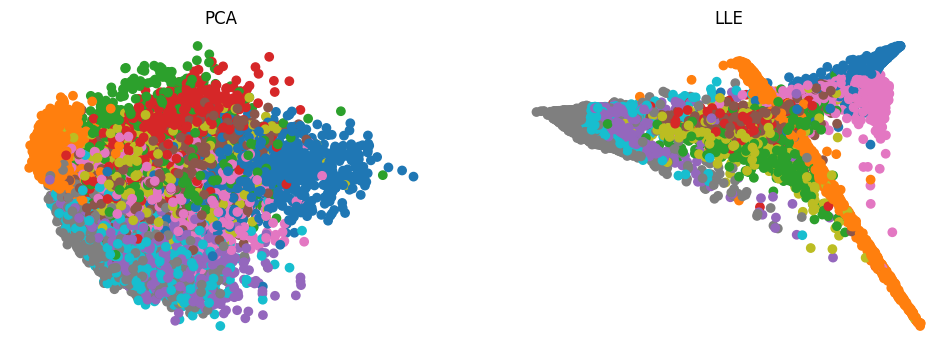

In [41]:
fig, axis = plt.subplots(1, 2, figsize=(12, 4))
axis[0].scatter(X_transformed[0][:,0], X_transformed[0][:,1], c=y_subset, cmap=plt.cm.tab10)
axis[0].set_title('PCA')
axis[1].scatter(X_transformed[1][:,0], X_transformed[1][:,1], c=y_subset, cmap=plt.cm.tab10)
axis[1].set_title('LLE')
axis[0].axis('off')
axis[1].axis('off')

As we can see, the results obtained using PCA and LLE are worse than the results obtained using t-SNE. However PCA is very fast, so we are going to use PCA to preserve 95% of the variance in the dataset and then use t-SNE to reduce the dimensionality down to 2 dimensions for visualization purposes

In [57]:
from sklearn.pipeline import Pipeline
pca_tsne = Pipeline([
    ("pca", PCA(n_components=0.95, random_state=42)),
    ("tsne", TSNE(n_components=2, random_state=42, n_jobs=-1)),
], verbose=True)
start = time.time()
X_pca_tsne = pca_tsne.fit_transform(X_train[indexes])
print("Time elapsed: {:.2f}s".format(time.time() - start))

[Pipeline] ............... (step 1 of 2) Processing pca, total=   1.9s
[Pipeline] .............. (step 2 of 2) Processing tsne, total= 1.3min
Time elapsed: 79.55s


(-89.90376815795898, 92.8516746520996, -92.56406288146972, 85.67095832824707)

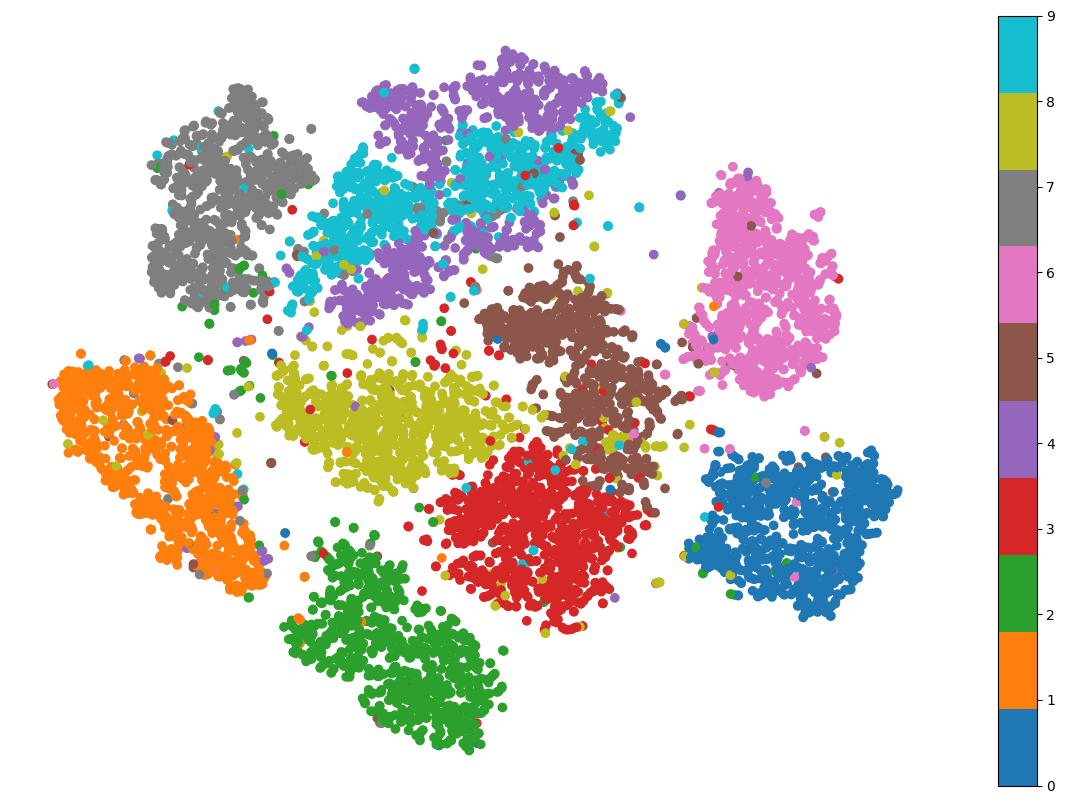

In [58]:
plt.figure(figsize=(15, 10))
plt.scatter(X_pca_tsne[:, 0], X_pca_tsne[:, 1], c=y_subset, cmap=plt.cm.tab10)
plt.colorbar()
plt.axis('off')

The results are very similar between t-SNE and PCA+t-SNE, however, the PCA+t-SNE is faster than t-SNE. The PCA+t-SNE is a good choice when the dataset is large and the dimensionality is high.